In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd 
import random
import math
from scipy.stats import expon
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from pandas import read_csv
from pandas.plotting import autocorrelation_plot
import scipy.optimize as optim

#from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
plt.style.use('seaborn')
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric


from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()

In [2]:
file_name = 'Covid19SN_datas.xlsx'
df_senegal = pd.read_excel(file_name, index_col=0)
df_senegal.shape
df_senegal = df_senegal.reset_index()
df_senegal['Date'] = pd.to_datetime(df_senegal['Date'])
df_senegal.tail()

,Country,lat,long,Date,Daily_case,Confirmed_cases,Imported_cases,Cum_Imported_cases,contacts,Cum_contacts,Communities_cases,Cum_communities_cases,Recovered,Cum_recored,Nb_tests,Cum_Nb_tests,Dead,Cum_Dead,evacuat_out,Cum_evacuat_out
49,Senegal,14.497448,-14.452448,2020-04-20,10,377,0,85,5,250,5,42,15,235,281,5303,2,5,0,1
50,Senegal,14.497449,-14.452449,2020-04-21,35,412,0,85,34,284,1,43,7,242,466,5769,0,5,0,1
51,Senegal,14.497450,-14.452450,2020-04-22,30,442,0,85,26,310,4,47,11,253,482,6251,1,6,0,1
52,Senegal,14.497451,-14.452451,2020-04-23,37,479,0,85,29,339,8,55,4,257,387,6638,0,6,0,1
53,Senegal,14.497452,-14.452452,2020-04-24,66,545,0,85,61,400,5,60,5,262,528,7166,1,7,0,1


In [3]:
def get_daily_var(ct,df):
    
    """
      This function takes the countries name and database in parameters.
      It returns a datframe with daily cases value and date as index
    """
    #Prepare country data
    ct_df = df[df['Country'] == ct]
    first_date = ct_df[ct_df['Confirmed_cases'] != 0]['Date'].values[0]
    confirmed = ct_df[ct_df['Date'] >= first_date]
    confirmed_cases = confirmed[['Date', 'Daily_case']].set_index('Date')
    
    
    return confirmed_cases

In [4]:
def get_pred_data (conf):
          
    """
      This function takes the daily dataframe and return it as arrays value
      for modelling purpose
    """
    #rearange dataframe values in array format
    cases_daily = np.array(conf).reshape(-1,1)
    cases_cum = np.array(conf.cumsum()).reshape(-1,1)
    days_since = np.arange(len(conf)).reshape(-1,1)
    
    return  cases_daily, cases_cum, days_since

In [5]:
def get_pred_date (n, conf):
    
    """
      This function generates n days for prediction
    """
    future_forcast = np.arange(len(conf) + n).reshape(-1,1)
    start_date = conf.index[0]
    future_forcast_dates = [(start_date + datetime.timedelta(days=i)).strftime('%d/%m/%Y') for i in range(len(future_forcast))] 
    
    return future_forcast,future_forcast_dates

In [7]:
cases_df = get_daily_var('Senegal',df_senegal)   
cases_daily, cases_cum, days_since = get_pred_data(cases_df)

# Modele ARMA

In [8]:
X = cases_daily
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

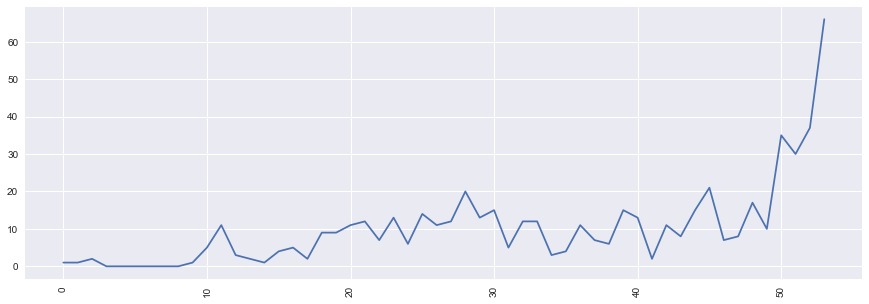

In [9]:
plt.figure(figsize=(15,5))
pyplot.plot(X)
pyplot.xticks(rotation = 90)
pyplot.show()

In [11]:
Y = cases_daily
#Y = confirmed_cases


train_size = int(len(Y) * 0.66)
train, test = Y[0:train_size], Y[train_size:len(Y)]
print('Observations: %d' % (len(Y)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 54
Training Observations: 35
Testing Observations: 19


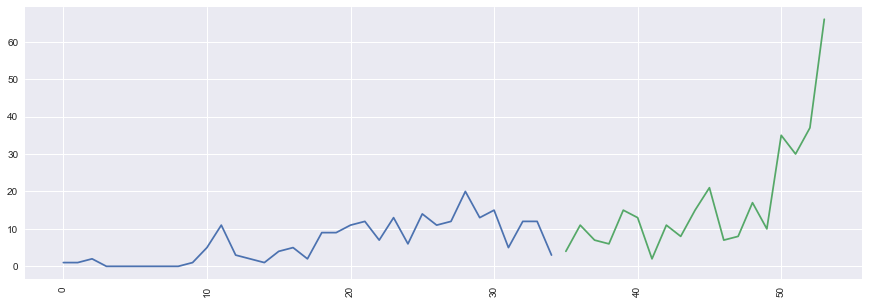

In [12]:
plt.figure(figsize=(15,5))
pyplot.plot(train)
pyplot.xticks(rotation = 90)
pyplot.plot([None for i in train] + [x for x in test])
pyplot.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   53
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -172.517
Method:                       css-mle   S.D. of innovations              6.186
Date:                Sat, 25 Apr 2020   AIC                            359.035
Time:                        16:00:21   BIC                            372.827
Sample:                             1   HQIC                           364.339
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3906      1.230      1.130      0.264      -1.021       3.802
ar.L1.D.y     -0.3062      0.149     -2.055      0.045      -0.598      -0.014
ar.L2.D.y     -0.0077      0.163     -0.047      0.9

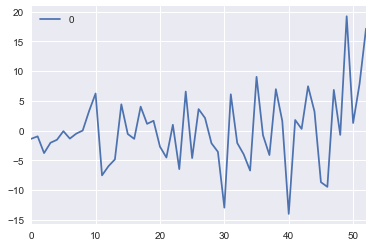

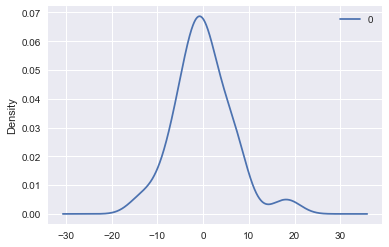

               0
count  53.000000
mean    0.052483
std     6.253976
min   -14.038705
25%    -3.799414
50%    -0.585022
75%     3.306174
max    19.241747


In [14]:
# fit model
model = ARIMA(X, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [46]:
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	#print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return  best_cfg

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 16)

In [25]:
import warnings
warnings.filterwarnings("ignore")
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(X, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=307.502
ARIMA(0, 0, 1) MSE=215.772
ARIMA(0, 0, 2) MSE=214.170
ARIMA(0, 1, 0) MSE=120.139
ARIMA(0, 1, 1) MSE=129.151
ARIMA(0, 2, 0) MSE=252.668
ARIMA(0, 2, 1) MSE=119.809
ARIMA(1, 0, 0) MSE=149.501
ARIMA(1, 1, 0) MSE=117.236
ARIMA(1, 1, 1) MSE=133.042
ARIMA(1, 2, 0) MSE=181.338
ARIMA(2, 0, 0) MSE=137.860
ARIMA(2, 1, 0) MSE=118.128
ARIMA(2, 1, 1) MSE=146.330
ARIMA(2, 2, 0) MSE=95.272
ARIMA(2, 2, 1) MSE=112.999
ARIMA(4, 0, 0) MSE=126.144
ARIMA(4, 1, 0) MSE=122.910
ARIMA(4, 1, 1) MSE=133.486
ARIMA(4, 1, 2) MSE=136.230
ARIMA(4, 2, 0) MSE=105.293
ARIMA(6, 0, 0) MSE=142.930
ARIMA(6, 1, 0) MSE=149.101
ARIMA(8, 0, 0) MSE=159.575
ARIMA(8, 1, 0) MSE=163.111
ARIMA(10, 1, 0) MSE=178.110
Best ARIMA(2, 2, 0) MSE=95.272


In [19]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error
 

In [21]:
 #load dataset


# evaluate parameters
p_values = [0, 1, 2, 4]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(X, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=307.502
ARIMA(0, 0, 1) MSE=215.772
ARIMA(0, 1, 0) MSE=120.139
ARIMA(0, 1, 1) MSE=129.151
ARIMA(1, 0, 0) MSE=149.501
ARIMA(1, 1, 0) MSE=117.236
ARIMA(1, 1, 1) MSE=133.042
ARIMA(2, 0, 0) MSE=137.860
ARIMA(2, 1, 0) MSE=118.128
ARIMA(2, 1, 1) MSE=146.330
ARIMA(4, 0, 0) MSE=126.144
ARIMA(4, 1, 0) MSE=122.910
ARIMA(4, 1, 1) MSE=133.486
Best ARIMA(1, 1, 0) MSE=117.236


predicted=7.393433, expected=4.000000
predicted=-1.578445, expected=11.000000
predicted=7.086032, expected=7.000000
predicted=11.310683, expected=6.000000
predicted=7.371517, expected=15.000000
predicted=12.447542, expected=13.000000
predicted=16.905855, expected=2.000000
predicted=5.520291, expected=11.000000
predicted=5.293450, expected=8.000000
predicted=4.773124, expected=15.000000
predicted=18.840543, expected=21.000000
predicted=22.815812, expected=7.000000
predicted=13.815360, expected=8.000000
predicted=5.831396, expected=17.000000
predicted=9.070252, expected=10.000000
predicted=13.269426, expected=35.000000
predicted=37.519901, expected=30.000000
predicted=37.627188, expected=37.000000
predicted=50.308738, expected=66.000000
Test MSE: 95.272


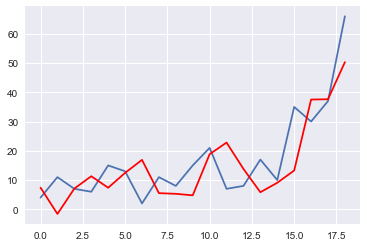

In [26]:
Xvalues = X
size = int(len(Xvalues) * 0.66)
train, test = Xvalues[0:size], Xvalues[size:len(Xvalues)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(2,2,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
def arima_mdoel(data,p_values, d_values, q_values):
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
#					print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
            
            

    size = int(len(data) * 0.66)
    train, test = data[0:size], data[size:len(data)]
    history = [x for x in train]
    predictions = list()
        for t in range(len(test)):
            model = ARIMA(history, order=(2,2,0))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
            print('predicted=%f, expected=%f' % (yhat, obs))
            error = mean_squared_error(test, predictions)
            print('Test MSE: %.3f' % error)
    # plot
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()  
    
    
    
    
    
    return